# Exploring Backpropagation

These notes accompany the [Backpropagation and MLP lesson](https://course.fast.ai/Lessons/lesson13.html#lesson-resources) from Jeremy Howard.  The associated workbook can be found here: [https://github.com/fastai/course22p2/blob/master/nbs/03_backprop.ipynb](https://github.com/fastai/course22p2/blob/master/nbs/03_backprop.ipynb)

## Loading Data

We start by loading MNIST.

In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
from pathlib import Path
import torch
from torch import tensor
from fastcore.test import test_close
from fastai.data.all import *
from fastai.vision.all import *
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

torch.manual_seed(42)

mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)

# path_data = Path('data')
# path_gz = path_data/'mnist.pkl.gz'
# with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
# x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/home/xstof/.fastai/data/mnist_png/training'),Path('/home/xstof/.fastai/data/mnist_png/testing')]

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

batch_size = 32

# Define the transformation to apply to the data
transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor(),  # convert PIL image to PyTorch tensor
     transforms.Normalize((0.5,), (0.5,))])  # normalize the data to have a mean of 0.5 and std of 0.5

# Load the training dataset
trainset = torchvision.datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transform)

# Create a data loader for the training dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size)
dataiter = iter(trainloader)
images, labels = dataiter.__next__()

In [3]:
images.shape, labels.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

As we can see, every image is stored with one explicit channel.  Let's simplify this by removing this dimension. In addition we'll concatenate all pixels.

In [4]:
images = images.view(32,28*28)
images.shape

torch.Size([32, 784])

This means, we have a batch of 32 images, each with 784 pixels (28 * 28).  Visuially that looks like this:

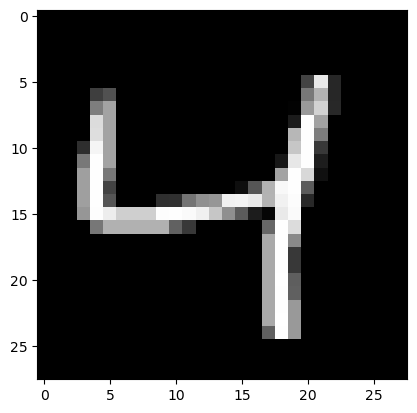

label for this image: 4


In [5]:
# Display the third image in the batch as an image
def show_image(img):
    plt.imshow(img.view(28,28), cmap='gray')
    plt.show()
show_image(images[2])
print(f"label for this image: {labels[2]}")

## Doing a Forward and Backward Pass

### Building the model

Let's set some parameters first:

- `nr_hidden`: number of hidden layers (50)
- `n`: number of images (32)
- `m`: number of pixels in every image (784)

In [8]:
nr_hidden = 50
n, m = images.shape

And let's assume some weights and biases for two layers of our neural net:

In [63]:
w1 = torch.randn(m, nr_hidden) # 784 x 50 (every hidden node has 784 inputs, 50 of them)
b1 = torch.zeros(nr_hidden)    # 50
w2 = torch.randn(nr_hidden, 1) # 50 x 1 (every end node has 50 inputs, 1 of them)
b2 = torch.zeros(1)            # 1

In [15]:
w1, w1.shape

(tensor([[ 0.25,  0.58,  0.80,  ..., -1.15,  0.85, -0.78],
         [-1.12, -0.24,  0.28,  ..., -0.76,  0.92,  0.53],
         [ 1.11,  0.82, -1.63,  ..., -0.63, -0.77,  1.05],
         ...,
         [ 0.51,  0.76, -0.02,  ...,  0.60, -0.22, -1.02],
         [ 1.35, -0.80, -1.00,  ..., -1.15, -1.02,  0.19],
         [ 0.35, -0.66,  2.23,  ..., -0.79,  0.29,  1.98]]),
 torch.Size([784, 50]))

In [26]:
w2[:5,:], w2.shape

(tensor([[ 0.15],
         [-0.10],
         [-0.63],
         [ 0.84],
         [ 1.20]]),
 torch.Size([50, 1]))

Let's define a simple lineair layer using these weights and biases.  The layer takes as input a vector x and calculates the output for each of it's output nodes (`nr_hidden` in this case for the first layer)

In [27]:
def lin(x, w, b): return x @ w + b

In [28]:
t = lin(images, w1, b1)
t.shape, t

(torch.Size([32, 50]),
 tensor([[ 10.32, -39.56, -13.43,  ...,  -1.25,  52.43, -27.01],
         [  6.32, -19.67,  10.22,  ...,  35.99,  74.31,  16.61],
         [ 33.00, -13.33,  13.57,  ...,  24.38,  27.36,   1.30],
         ...,
         [ 15.04, -54.34,  33.99,  ..., -13.76,  59.42,   7.30],
         [ 39.27, -66.01,   4.90,  ...,  -0.77,  49.98,  11.18],
         [-32.05, -47.28,  10.01,  ...,  19.10,  69.69,   7.22]]))

So, when we put our training batch (`images`) through a linear layer defined by `w1` and `b1`, we get back a tensor 32 rows (our 32 images in the batch) and for each image/row a set of 50 values.  One for each of our hidden layer neurons.

Let's define a non-linear function now:

In [29]:
def relu(x): return x.clamp_min(0.)

In [30]:
t = relu(t)
t.shape, t

(torch.Size([32, 50]),
 tensor([[10.32,  0.00,  0.00,  ...,  0.00, 52.43,  0.00],
         [ 6.32,  0.00, 10.22,  ..., 35.99, 74.31, 16.61],
         [33.00,  0.00, 13.57,  ..., 24.38, 27.36,  1.30],
         ...,
         [15.04,  0.00, 33.99,  ...,  0.00, 59.42,  7.30],
         [39.27,  0.00,  4.90,  ...,  0.00, 49.98, 11.18],
         [ 0.00,  0.00, 10.01,  ..., 19.10, 69.69,  7.22]]))

The shape did not change, but any element below 0 is brought back to zero now.

Our entire two-layer model now can be defined like this:

In [31]:
def model(x):
    l1 = lin(x, w1, b1)
    l2 = relu(l1)
    return lin(l2, w2, b2)

In [34]:
res = model(images)
res.shape, res[:5,:]

(torch.Size([32, 1]),
 tensor([[ -86.24],
         [  -8.37],
         [ -40.68],
         [ -88.72],
         [-139.06]]))

This is the resulting output of our neural net: one result for each of our input images in our batch of 32.

### Define a loss function

We'll define a completely wrong, unreasonable loss function here, for our learning purposes.  We'll replace this later by something more relevant.  We'll use a Mean Square Error or MSE function.

Our loss is always defined between the predicted output of our neural net and the actual truth values:

In [35]:
x_train = images
y_train = labels

res.shape, y_train.shape

(torch.Size([32, 1]), torch.Size([32]))

Let's substract the truth values from the network's output:

In [40]:
(res - y_train).shape

torch.Size([32, 32])

In [41]:
(res - y_train)

tensor([[ -91.24,  -86.24,  -90.24,  ...,  -93.24,  -89.24,  -94.24],
        [ -13.37,   -8.37,  -12.37,  ...,  -15.37,  -11.37,  -16.37],
        [ -45.68,  -40.68,  -44.68,  ...,  -47.68,  -43.68,  -48.68],
        ...,
        [ -46.43,  -41.43,  -45.43,  ...,  -48.43,  -44.43,  -49.43],
        [-132.75, -127.75, -131.75,  ..., -134.75, -130.75, -135.75],
        [-150.83, -145.83, -149.83,  ..., -152.83, -148.83, -153.83]])

What does this mean?  When we subtract y_train values from res, we're doing broadcasting.  This does not pan out like we would like it to be.  `res` looks like this and has a dimension too much:

In [43]:
res[:5,:] 

tensor([[ -86.24],
        [  -8.37],
        [ -40.68],
        [ -88.72],
        [-139.06]])

Let's remove this dimension:

In [44]:
res.view(-1)

tensor([ -86.24,   -8.37,  -40.68,  -88.72, -139.06,  -21.66,  -88.79,  -54.04, -113.56,  -50.79,  -97.39,  -52.44, -154.46,
         -55.64,  -96.86,  -62.93,  -68.99, -168.57, -166.04,  -81.36,  -97.52,   21.72,  -99.52,  -83.41, -116.91, -150.95,
         -62.47,  -96.60,  -70.09,  -41.43, -127.75, -145.83])

an alternative to this way of doing this is:

In [46]:
res.squeeze()

tensor([ -86.24,   -8.37,  -40.68,  -88.72, -139.06,  -21.66,  -88.79,  -54.04, -113.56,  -50.79,  -97.39,  -52.44, -154.46,
         -55.64,  -96.86,  -62.93,  -68.99, -168.57, -166.04,  -81.36,  -97.52,   21.72,  -99.52,  -83.41, -116.91, -150.95,
         -62.47,  -96.60,  -70.09,  -41.43, -127.75, -145.83])

Or just like this:

In [48]:
res[:,0]

tensor([ -86.24,   -8.37,  -40.68,  -88.72, -139.06,  -21.66,  -88.79,  -54.04, -113.56,  -50.79,  -97.39,  -52.44, -154.46,
         -55.64,  -96.86,  -62.93,  -68.99, -168.57, -166.04,  -81.36,  -97.52,   21.72,  -99.52,  -83.41, -116.91, -150.95,
         -62.47,  -96.60,  -70.09,  -41.43, -127.75, -145.83])

Back to our MSE:

In [52]:
(res[:,0]-y_train).shape

torch.Size([32])

In [53]:
def mse(output, targ): return (output[:,0]-targ).pow(2).mean()

In [54]:
preds = model(x_train)

In [55]:
mse(preds, y_train)

tensor(10262.35)

### Gradients and backwards pass

Our forward and pass looks like:

In [60]:
inp, targ = x_train, y_train
l1 = lin(inp, w1, b1)
l2 = relu(l1)
out = lin(l2, w2, b2)
diff = out[:,0]-targ
loss = diff.pow(2).mean()

loss

tensor(10262.35)

For the backward pass we now need to work backwards using the gradients.  

We'll store the gradients on the variables themselves.  Let's start with our loss.  This is defined like $$\frac{\sum_{i=0}^{n}(out_i-targ_i)^2}{n}$$ or $$\frac{\sum_{i=0}^{n}(x_i-y_i)^2}{n}$$

The [derivative of this](https://www.wolframalpha.com/input?i2d=true&i=Partial%5BDivide%5BPower%5Bx_0-y_0%2C2%5D%2Cn%5D%2Cx_0%5D) with respect to for example $x_0$ is:

$$\frac{2(x_0-y_0)}{n}$$

In this equation, n is equal to the number of elements in our input (like in: `inp.shape[0]`)

In [62]:
out.g = 2.*diff / inp.shape[0]
out.g

tensor([ -5.70,  -0.52,  -2.79,  -5.61,  -9.25,  -1.48,  -5.61,  -3.56,  -7.16,  -3.42,  -6.27,  -3.59,  -9.84,  -3.85,
         -6.12,  -4.37,  -4.44, -11.04, -10.75,  -5.65,  -6.34,   1.36,  -6.78,  -5.28,  -7.37,  -9.56,  -4.15,  -6.23,
         -4.51,  -3.03,  -8.17,  -9.61])

What do these mean?  Each of those numbers is an indication to: "if I change this out param (the result of the last linear layer), then how much does that influence the loss?"

We now need to calculate the gradient of our linear layer.  We will determine how much the change of each param out of which our lineair layer consist has an influence on its output.  Let's consider the single output neuron $o$ from layer l3 (as it only has one output neuron). Its output is determined by the formula:

$$o = (l2_0 . w2_0 + l2_1 . w2_1 + ... + l2_{50}) + b2$$

what is now the derivate of this function with regards to, let's say $w2_3$?



In [ ]:
def lin_grad(inp, out, w, b):
    inp.g 